## Latent Integration Network (LIN)
This notebook gives an example of how to train a LIN on SVD vectors. Note: 05_experiment_SVD.ipynb created and saved the SVD Decomposition. 

## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.mantaflowDatasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage, \
                                    pkl_save, pkl_load, reconFrame

#from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

from surrogates4sims.svd import MantaFlowSVDDataset

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "LIN_manta_SVD_MLP"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 
SVDFn = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/svd/svd.pkl'
svd_vec_file = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/svd/mantaSVDvecs.pkl'
FakeData = True

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 1

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 64
numSamplesToKeep = np.infty #if not debugging
latentDim = 512
simLen = 200

w = 30
numComponents = 16 # this does not include p. so the vectors will be of size numComponents + len(p)
hiddenLayers = [128,128]
hd ='_'.join(map(str,hiddenLayers))
activation = nn.Tanh()

if DEBUG:
    epochs = 2
    numSamplesToKeep = 200
    createDebugData = True
    

versionName = versionName + '_w{}_latentDim{}_hd{}_bz{}_epochs{}'.format(w,numComponents,hd,bz,epochs)
versionName

'LIN_manta_SVD_MLP_GPUs0_w30_latentDim16_hd128_128_bz64_epochs1000'

## Select Personal GPUs

In [ ]:
!nvidia-smi

Tue Oct 13 08:39:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |    547MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 17%   25C    P0    56W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Tue Oct 13 08:39:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   21C    P2    59W / 250W |    547MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 17%   25C    P0    56W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Build Latent Vectors (Warning....)
The computation of building the latent vectors takes a loooong time. 
This codes checks to see if svd_vec_file has been saved. If it has, 
it will reload them. 

In [ ]:
if FakeData:
    from scipy.stats import ortho_group 
    numTrainSamps = 100
    numTestSamps = 10
    simLen
    A = ortho_group.rvs(dim=numComponents)
    p = np.random.randn(simLen,3).astype('float32')
    def makeSample(A,p,simLen=200):
        x = np.random.randn(numComponents,)
        X = [x.copy()]
        for i in range(simLen):
            x = np.matmul(A,x)
            X.append(x.copy())
        #p = np.zeros((simLen,3)).astype('float32')
        X = np.array(X).astype('float32')
        return X[:simLen], p

    train_data = []
    for i in range(numTrainSamps):
        train_data.append(makeSample(A,p))
    #train_data = np.array(train_data)
    
    test_data = []
    for i in range(numTestSamps):
        test_data.append(makeSample(A,p))
    #test_data = np.array(test_data)
    
else:
    if os.path.exists(svd_vec_file):
        data = pkl_load(svd_vec_file)
        train_data = data['train_data']
        test_data = data['test_data']
    else:
        svd_data = pkl_load(SVDFn)
        print(svd_data.keys())

        svd_vecs = svd_data['spatialVecs'][:,:numComponents]
        print(svd_vecs.shape)

        trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
        print((len(trainData),len(testData)))

        def createSVDdataset(trainData):

            # datasets may be smaller because: numSamplesToKeep 
            # Be careful the default is for the data to be preprocessed. Therefore, we have to invPrecprocess if 
            # we are looking at relative errors. 
            trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
            trainDataLoader = DataLoader(dataset=trainDataset, batch_size=len(trainDataset))
            X_train,p_train = next(iter(trainDataLoader))
            print(X_train.shape, p_train.shape)
            z_train = list(map(lambda x: reconFrame(svd_vecs, x, numComponents),X_train.numpy()))

            train_recons, latent_vec_train = zip(*z_train)
            train_recons = np.array(train_recons)
            latent_vec_train = np.array(latent_vec_train)

            v = np.arange(0,len(latent_vec_train),simLen)

            sims = []
            for idx in v:
                sims.append((latent_vec_train[idx:idx+simLen],p_train[idx:idx+simLen]))
            sims = np.array(sims)
            print('num_sims {}'.format(len(sims)))
            return sims

        train_data = createSVDdataset(trainData)
        test_data = createSVDdataset(testData)
        D = {'train_data':train_data,'test_data':test_data}
        pkl_save(D,svd_vec_file)

In [ ]:
train_data[0][0].shape, train_data[0][1].shape

((200, 16), (200, 3))

In [ ]:
# reduce the dimensions of z down to the numComponents 
for idx,d in enumerate(train_data):
    X = d[0][:,:numComponents]
    p = d[1]
    train_data[idx] = (X,p)
    
for idx,d in enumerate(test_data):
    X = d[0][:,:numComponents]
    p = d[1]
    test_data[idx] = (X,p)

## Investigate how to preprocess the data

In [ ]:
len(train_data), len(test_data)

(100, 10)

In [ ]:
D = []
for d in train_data:
    D.append(np.hstack(d))
D = np.vstack(D)
D.shape

(20000, 19)

In [ ]:
D.max()

4.0296187

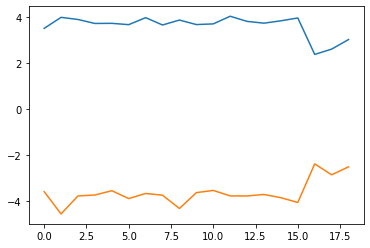

In [ ]:
x_mx = np.max(D,axis=0)
x_mn = np.min(D,axis=0)
plt.plot(x_mx)
plt.plot(x_mn)
plt.show()

## Dataset and Dataloader

In [ ]:
class LatentVectors(Dataset):
    def __init__(self, data,doPreprocess=False,w=1,simLen=200,mx=x_mx,mn=x_mn):
        self.data = data
        self.doPreprocess = doPreprocess
        self.simLen = simLen
        self.w = w
        self.mx = mx
        self.mn = mn
                 
    def __len__(self):
        return self.simLen*len(self.data)

    def preprocess(self,x):
        xnew = 2*((x-self.mn)/(self.mx-self.mn) - .5)
        return xnew

    def invPreprocess(self,xnew):
        x = ((xnew/2)+.5)*(self.mx-self.mn) + self.mn
        return x
    
    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        X,p = self.data[q]
        r_idx = np.random.randint(0,self.simLen-self.w)
        x = np.hstack([X[r_idx:r_idx+1],p[r_idx:r_idx+1]])
        #print(x.shape)
        y = np.hstack([X[r_idx+1:r_idx+self.w+1],p[r_idx+1:r_idx+self.w+1]])
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocess(x)
            y = self.preprocess(y)
        return x, y

In [ ]:
trainDataset = LatentVectors(train_data,doPreprocess=True,w=w,simLen=200,mx=x_mx,mn=x_mn)
testDataset = LatentVectors(test_data,doPreprocess=True,w=w,simLen=200,mx=x_mx,mn=x_mn)

In [ ]:
X,y = trainDataset[4]
X.shape,y.shape

((1, 19), (30, 19))

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataset), len(trainDataLoader), len(testDataset), len(testDataLoader)

(20000, 312, 2000, 32)

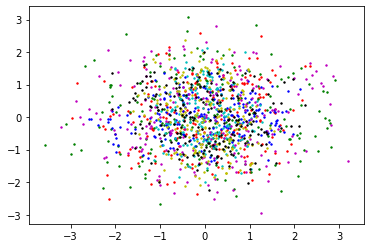

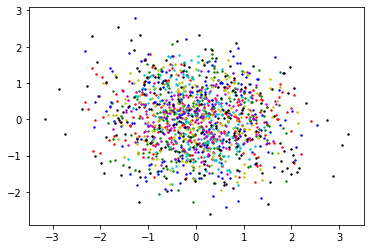

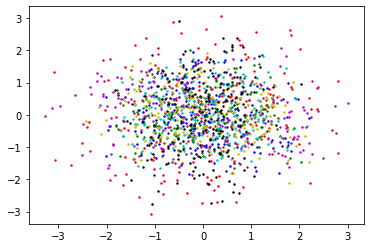

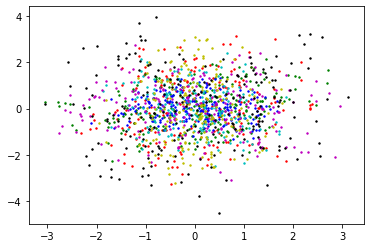

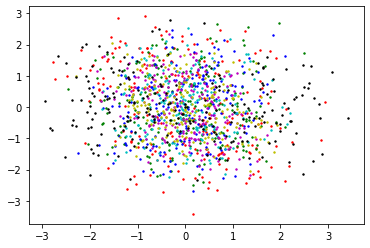

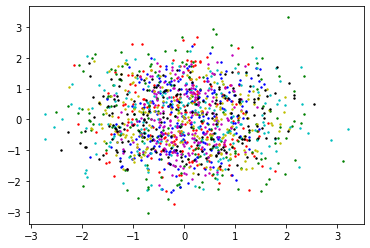

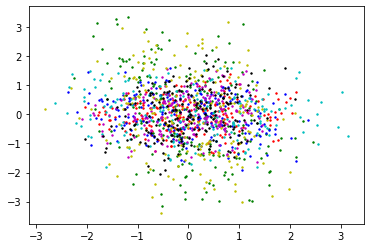

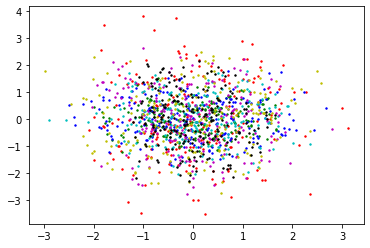

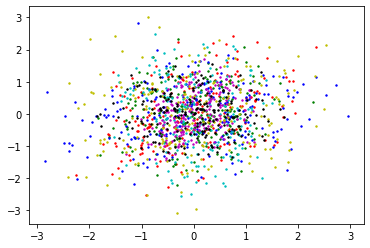

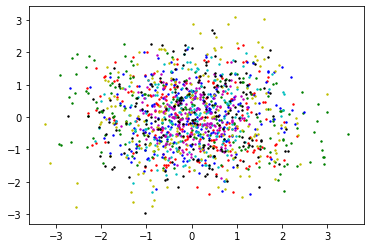

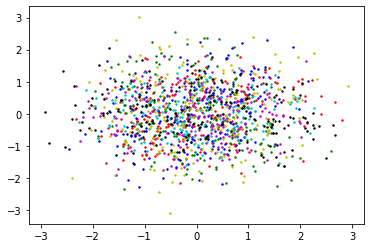

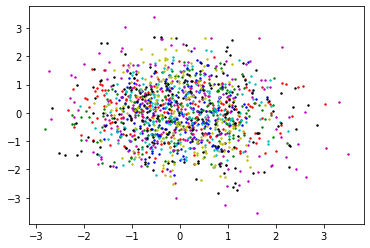

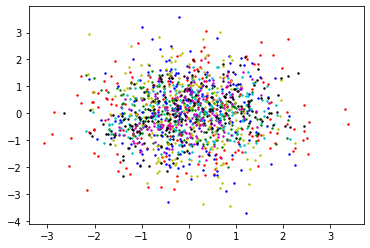

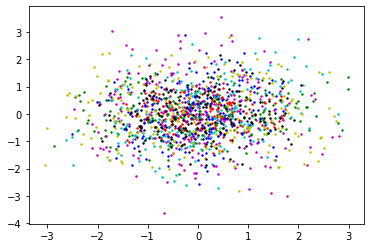

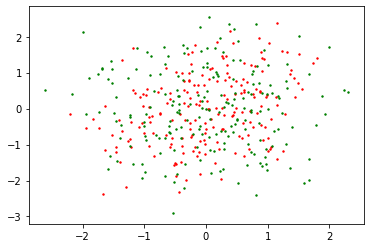

In [ ]:
# plot the first 2 coordinates of the first 3 simulations
# this makes me think that this is going to be a hard problem. 
Dplot = D.reshape(len(train_data),simLen,-1)
colors = ['r','g','b','c','m','y','k']
nc = len(colors)
for sim in range(0,len(train_data),nc):
    A = Dplot[sim:sim+nc]
    for idx, x in enumerate(A):
        plt.scatter(x[:,0],x[:,1],c=colors[idx],s=2)
    plt.show()

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [ ]:
X,y = next(iter(trainDataLoader))
X.shape, y.shape

(torch.Size([64, 1, 19]), torch.Size([64, 30, 19]))

In [ ]:
model = MLP(X, hiddenLayerSizes=hiddenLayers,activation=activation)
model

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
output = model(X)
output.shape

torch.Size([64, 1, 19])

In [ ]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

6 layers require gradients (unfrozen) out of 6 layers
21,523 parameters require gradients (unfrozen) out of 21,523 parameters


## Loss Function

In [ ]:
L = nn.MSELoss()

In [ ]:
L(output,y[:,0:1,:])

tensor(0.0994, grad_fn=<MseLossBackward>)

In [ ]:
sum_loss = 0
out = X.clone()
for idx in range(w):
    out = model(out).clone()
    sum_loss += L(out,y[:,idx:idx+1,:])
sum_loss

tensor(2.7957, grad_fn=<AddBackward0>)

In [ ]:
combined_loss = L(output,y)
combined_loss.backward()

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64, 30, 19])) that is different to the input size (torch.Size([64, 1, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



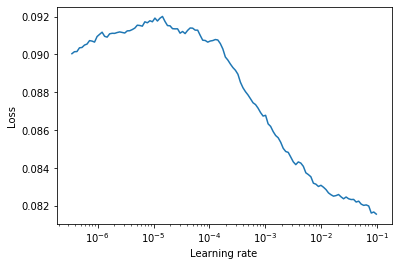

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)


In [ ]:
max_lr = .001
opt = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

In [ ]:
versionName

'LIN_manta_SVD_MLP_GPUs0_w30_latentDim16_hd128_128_bz64_epochs1000_lr0.001_lr0.001'

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        combined_loss = 0.
        
        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        y_hat = X.clone()
        predictions = []
        for w_idx in range(w):
            y_hat = model(y_hat).clone()
            y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
            predictions.append(y_hat)
            combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps


In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        combined_loss = 0.
        # --- Metrics Recording ---

        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # forward, no gradient calculations
        with torch.no_grad():
            y_hat = X.clone()
            predictions = []
            for w_idx in range(w):
                y_hat = model(y_hat).clone()
                y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
                predictions.append(y_hat)
                combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])

        running_loss += combined_loss.item()

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

    avg_running_loss = running_loss/len(myDataLoader)
    avg_running_rmse = running_rmse/len(myDataLoader)
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return avg_running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
model = model.to(device)
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, L,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, L, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

    #checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    #lr_scheduler.step(valLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)




  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 9.2789e-01
LR: 1.0000e-03
Better trainLoss: 9.2789e-01, Saving models...





  0%|          | 1/1000 [00:12<3:24:33, 12.29s/it]

valLoss: 4.2357e-01
Better valLoss: 4.2357e-01, Saving models...
--- Epoch 2/1000 ---
trainLoss: 1.0994e-01
LR: 1.0000e-03
Better trainLoss: 1.0994e-01, Saving models...





  0%|          | 2/1000 [00:23<3:19:23, 11.99s/it]

valLoss: 3.3331e-02
Better valLoss: 3.3331e-02, Saving models...
--- Epoch 3/1000 ---
trainLoss: 2.6757e-02
LR: 1.0000e-03
Better trainLoss: 2.6757e-02, Saving models...





  0%|          | 3/1000 [00:35<3:16:46, 11.84s/it]

valLoss: 2.6879e-02
--- Epoch 4/1000 ---
trainLoss: 2.5523e-02
LR: 1.0000e-03
Better trainLoss: 2.5523e-02, Saving models...





  0%|          | 4/1000 [00:46<3:15:29, 11.78s/it]

valLoss: 2.7571e-02
--- Epoch 5/1000 ---
trainLoss: 2.4114e-02
LR: 1.0000e-03
Better trainLoss: 2.4114e-02, Saving models...





  0%|          | 5/1000 [00:57<3:12:38, 11.62s/it]

valLoss: 3.1031e-02
--- Epoch 6/1000 ---
trainLoss: 2.3133e-02
LR: 1.0000e-03
Better trainLoss: 2.3133e-02, Saving models...





  1%|          | 6/1000 [01:09<3:11:54, 11.58s/it]

valLoss: 2.8707e-02
--- Epoch 7/1000 ---
trainLoss: 2.3011e-02
LR: 1.0000e-03
Better trainLoss: 2.3011e-02, Saving models...





  1%|          | 7/1000 [01:21<3:13:26, 11.69s/it]

valLoss: 2.5744e-02
--- Epoch 8/1000 ---
trainLoss: 2.1249e-02
LR: 1.0000e-03
Better trainLoss: 2.1249e-02, Saving models...





  1%|          | 8/1000 [01:33<3:14:23, 11.76s/it]

valLoss: 2.0924e-02
Better valLoss: 2.0924e-02, Saving models...
--- Epoch 9/1000 ---
trainLoss: 1.9991e-02
LR: 1.0000e-03
Better trainLoss: 1.9991e-02, Saving models...





  1%|          | 9/1000 [01:44<3:13:15, 11.70s/it]

valLoss: 2.6642e-02
--- Epoch 10/1000 ---
trainLoss: 1.9541e-02
LR: 1.0000e-03
Better trainLoss: 1.9541e-02, Saving models...





  1%|          | 10/1000 [01:56<3:13:59, 11.76s/it]

valLoss: 3.0337e-02
--- Epoch 11/1000 ---
trainLoss: 1.9343e-02
LR: 1.0000e-03
Better trainLoss: 1.9343e-02, Saving models...





  1%|          | 11/1000 [02:07<3:10:05, 11.53s/it]

valLoss: 2.5517e-02
--- Epoch 12/1000 ---
trainLoss: 1.8240e-02
LR: 1.0000e-03
Better trainLoss: 1.8240e-02, Saving models...





  1%|          | 12/1000 [02:19<3:09:20, 11.50s/it]

valLoss: 2.3883e-02
--- Epoch 13/1000 ---
trainLoss: 1.7290e-02
LR: 1.0000e-03
Better trainLoss: 1.7290e-02, Saving models...





  1%|▏         | 13/1000 [02:31<3:11:57, 11.67s/it]

valLoss: 2.2408e-02
--- Epoch 14/1000 ---
trainLoss: 1.7105e-02
LR: 1.0000e-03
Better trainLoss: 1.7105e-02, Saving models...





  1%|▏         | 14/1000 [02:42<3:08:14, 11.46s/it]

valLoss: 3.1461e-02
--- Epoch 15/1000 ---
trainLoss: 1.6447e-02
LR: 1.0000e-03
Better trainLoss: 1.6447e-02, Saving models...





  2%|▏         | 15/1000 [02:53<3:09:13, 11.53s/it]

valLoss: 2.4315e-02
--- Epoch 16/1000 ---
trainLoss: 1.5805e-02
LR: 1.0000e-03
Better trainLoss: 1.5805e-02, Saving models...





  2%|▏         | 16/1000 [03:05<3:07:41, 11.44s/it]

valLoss: 2.6545e-02
--- Epoch 17/1000 ---
trainLoss: 1.5530e-02
LR: 1.0000e-03
Better trainLoss: 1.5530e-02, Saving models...





  2%|▏         | 17/1000 [03:16<3:07:26, 11.44s/it]

valLoss: 1.7474e-02
--- Epoch 18/1000 ---
trainLoss: 1.4651e-02
LR: 1.0000e-03
Better trainLoss: 1.4651e-02, Saving models...





  2%|▏         | 18/1000 [03:28<3:07:08, 11.43s/it]

valLoss: 1.7082e-02
--- Epoch 19/1000 ---
trainLoss: 1.4654e-02
LR: 1.0000e-03





  2%|▏         | 19/1000 [03:39<3:09:39, 11.60s/it]

valLoss: 1.6627e-02
--- Epoch 20/1000 ---
trainLoss: 1.3903e-02
LR: 1.0000e-03
Better trainLoss: 1.3903e-02, Saving models...





  2%|▏         | 20/1000 [03:51<3:07:33, 11.48s/it]

valLoss: 2.6930e-02
--- Epoch 21/1000 ---
trainLoss: 1.3350e-02
LR: 1.0000e-03
Better trainLoss: 1.3350e-02, Saving models...





  2%|▏         | 21/1000 [04:02<3:07:15, 11.48s/it]

valLoss: 1.4393e-02
--- Epoch 22/1000 ---
trainLoss: 1.3226e-02
LR: 1.0000e-03
Better trainLoss: 1.3226e-02, Saving models...





  2%|▏         | 22/1000 [04:14<3:09:44, 11.64s/it]

valLoss: 3.4171e-02
--- Epoch 23/1000 ---
trainLoss: 1.6744e-02
LR: 1.0000e-03





  2%|▏         | 23/1000 [04:26<3:10:54, 11.72s/it]

valLoss: 1.7139e-02
--- Epoch 24/1000 ---
trainLoss: 1.2059e-02
LR: 1.0000e-03
Better trainLoss: 1.2059e-02, Saving models...





  2%|▏         | 24/1000 [04:38<3:11:27, 11.77s/it]

valLoss: 1.7519e-02
--- Epoch 25/1000 ---
trainLoss: 1.2189e-02
LR: 1.0000e-03





  2%|▎         | 25/1000 [04:48<3:04:10, 11.33s/it]

valLoss: 1.2742e-02
--- Epoch 26/1000 ---
trainLoss: 1.0951e-02
LR: 1.0000e-03
Better trainLoss: 1.0951e-02, Saving models...





  3%|▎         | 26/1000 [05:00<3:05:51, 11.45s/it]

valLoss: 2.0727e-02
--- Epoch 27/1000 ---
trainLoss: 1.2293e-02
LR: 1.0000e-03





  3%|▎         | 27/1000 [05:11<3:05:05, 11.41s/it]

valLoss: 1.3647e-02
--- Epoch 28/1000 ---
trainLoss: 1.2913e-02
LR: 1.0000e-03





  3%|▎         | 28/1000 [05:23<3:04:16, 11.38s/it]

valLoss: 1.4924e-02
--- Epoch 29/1000 ---
trainLoss: 7.5791e-03
LR: 1.0000e-04
Better trainLoss: 7.5791e-03, Saving models...





  3%|▎         | 29/1000 [05:33<2:58:34, 11.03s/it]

valLoss: 1.1792e-02
--- Epoch 30/1000 ---
trainLoss: 7.5214e-03
LR: 1.0000e-04
Better trainLoss: 7.5214e-03, Saving models...





  3%|▎         | 30/1000 [05:43<2:56:04, 10.89s/it]

valLoss: 1.0204e-02
--- Epoch 31/1000 ---
trainLoss: 7.5139e-03
LR: 1.0000e-04
Better trainLoss: 7.5139e-03, Saving models...





  3%|▎         | 31/1000 [05:55<2:59:00, 11.08s/it]

valLoss: 1.3161e-02
--- Epoch 32/1000 ---
trainLoss: 7.4783e-03
LR: 1.0000e-04
Better trainLoss: 7.4783e-03, Saving models...





  3%|▎         | 32/1000 [06:07<3:05:31, 11.50s/it]

valLoss: 1.0885e-02
--- Epoch 33/1000 ---
trainLoss: 7.5112e-03
LR: 1.0000e-04





  3%|▎         | 33/1000 [06:20<3:08:49, 11.72s/it]

valLoss: 1.1732e-02
--- Epoch 34/1000 ---
trainLoss: 7.4181e-03
LR: 1.0000e-04
Better trainLoss: 7.4181e-03, Saving models...





  3%|▎         | 34/1000 [06:32<3:12:33, 11.96s/it]

valLoss: 1.1351e-02
--- Epoch 35/1000 ---
trainLoss: 7.4680e-03
LR: 1.0000e-04





  4%|▎         | 35/1000 [06:43<3:08:18, 11.71s/it]

valLoss: 1.0980e-02
--- Epoch 36/1000 ---
trainLoss: 7.4499e-03
LR: 1.0000e-04





  4%|▎         | 36/1000 [06:55<3:08:09, 11.71s/it]

valLoss: 1.1147e-02
--- Epoch 37/1000 ---
trainLoss: 7.1024e-03
LR: 1.0000e-05
Better trainLoss: 7.1024e-03, Saving models...





  4%|▎         | 37/1000 [07:06<3:02:33, 11.37s/it]

valLoss: 1.0627e-02
--- Epoch 38/1000 ---
trainLoss: 7.0743e-03
LR: 1.0000e-05
Better trainLoss: 7.0743e-03, Saving models...





  4%|▍         | 38/1000 [07:17<3:03:32, 11.45s/it]

valLoss: 1.0500e-02
--- Epoch 39/1000 ---
trainLoss: 7.0889e-03
LR: 1.0000e-05





  4%|▍         | 39/1000 [07:29<3:06:16, 11.63s/it]

valLoss: 1.0739e-02
--- Epoch 40/1000 ---
trainLoss: 7.0809e-03
LR: 1.0000e-05





  4%|▍         | 40/1000 [07:40<3:03:46, 11.49s/it]

valLoss: 1.0362e-02
--- Epoch 41/1000 ---
trainLoss: 7.0394e-03
LR: 1.0000e-06
Better trainLoss: 7.0394e-03, Saving models...





  4%|▍         | 41/1000 [07:51<2:59:47, 11.25s/it]

valLoss: 1.0697e-02
--- Epoch 42/1000 ---
trainLoss: 7.0413e-03
LR: 1.0000e-06





  4%|▍         | 42/1000 [08:02<2:58:30, 11.18s/it]

valLoss: 1.0881e-02
--- Epoch 43/1000 ---
trainLoss: 7.0425e-03
LR: 1.0000e-06





  4%|▍         | 43/1000 [08:15<3:04:36, 11.57s/it]

valLoss: 1.0474e-02
--- Epoch 44/1000 ---
trainLoss: 7.0361e-03
LR: 1.0000e-07
Better trainLoss: 7.0361e-03, Saving models...





  4%|▍         | 44/1000 [08:27<3:09:41, 11.91s/it]

valLoss: 1.0572e-02
--- Epoch 45/1000 ---
trainLoss: 7.0406e-03
LR: 1.0000e-07





  4%|▍         | 45/1000 [08:38<3:04:55, 11.62s/it]

valLoss: 1.0659e-02
--- Epoch 46/1000 ---
trainLoss: 7.0365e-03
LR: 1.0000e-07
valLoss: 1.0558e-02
---------- Finished Training ----------


## Test on the last trained model on Full simLen

In [ ]:
model.eval()

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
def invPreprocess(xnew):
    x = ((xnew/2)+.5)*(x_mx-x_mn) + x_mn
    return x


def test_model(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X.shape, y.shape

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()

    yy = y.squeeze().to(device)
    err = []
    for i in range(out.shape[0]):
        e = invPreprocess(yy[i].detach().cpu().numpy()) - invPreprocess(out[i].detach().cpu().numpy())
        err.append(np.linalg.norm(e))

    if doPlot:
        plt.plot(err)
        plt.title('Test Sample'.format(test_ind))
        
    return err

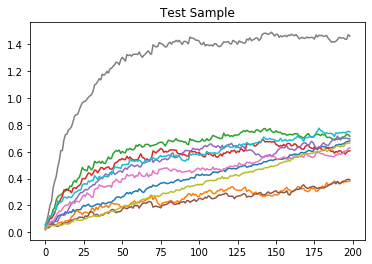

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

0.5196094

In [ ]:
## Test on the best validation model on Full simLen

In [ ]:
# best val loss model
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

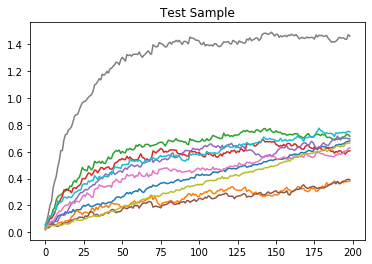

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

0.5196094

In [ ]:
idx = 0 # choose one of the test samples
testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
X,y = next(iter(testDataLoader))
X.shape, y.shape

(torch.Size([1, 1, 19]), torch.Size([1, 199, 19]))

In [ ]:
y[:,:,0]

tensor([[ 0.0286, -0.0122,  0.0009,  0.0124,  0.0118,  0.0116,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,  0.0115,
          0.0115,  0.0115,  

In [ ]:
xhat = X.to(device).clone()
out = []
for idx in range(y.shape[1]):
    xhat = model(xhat).clone()
    xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
    out.append(xhat)
out = torch.stack(out).squeeze()

yy = y.squeeze().to(device)
err = []
for i in range(out.shape[0]):
    e = invPreprocess(yy[i].detach().cpu().numpy()) - invPreprocess(out[i].detach().cpu().numpy())
    err.append(np.linalg.norm(e))